# Bulk Import to Load the Necessary Libraries 

In [1]:
import pymysql
import pandas as pd
import math

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import wikipedia
import spacy
from textblob import TextBlob
from IPython.display import Image
from collections import defaultdict


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, LinearRegression,BayesianRidge
from sklearn.pipeline import Pipeline

from scipy import sparse
from sklearn.metrics import pairwise_distances

In [2]:

pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Project Goal 

The goal of this project is to implement a machine learning model to provide restaurant recommendations to users based on prior reviews and preferences. In the long term the model can be applied to other categories of businesses like 'Hair Salons', 'Coffee Shops' and so on 

# Proposed Methods and Models 

The recommender system is going to be implemented using the following approaches 
1. Collaborative Filtering Mechanism  - Item/Item & User/User 
2. Content Based Filtering Mechanism 
3. Hybrid approach 

# Risk

1. Personally, everything I am doing in this topic is new to me. Hence I am learning as I go 
2. Might need more computing power (either an AWS or some other cloud hosted solution) to run the model
3. Still trying to figure out the best evaluation methods for the recommender system

# Assumption 

There is almost an overload of data. Hence, we will have to parse out some chunks of the dats while building and testing the model 

# Initial Goals

1. Retrieve the data from yelp 
2. Set up a MYSQL instance to load the SQL version of the data 
3. Load the data from MYSQL to Pandas for further analysis 
4. Perform some basic EDA on the important features
5. Build out a simple Collaborative model 
6. Build out a simple Content based model 
7. Using 5 & 6 build out a hydrid model 
8. Test the model for accurancy 

**Stretch Goal:**  Build out a UI for the model in either flask or Tkinter. 


The data for this project is hosted in a MYSQL database. Data is retrieved from MYSQL to a pandas dataframe

# Initial Data Load

### Setting up the connection for MYSQL 

In [3]:
conn = pymysql.connect(host='localhost', port=3306, user='root', passwd='test123', db='mysql')
cur = conn.cursor()

### Loading up the DataFrames from MYSQL

In [4]:
business_df = pd.read_sql('select * from yelp_db.business', con=conn)

In [5]:
user_df = pd.read_sql('select * from yelp_db.user', con=conn)

In [6]:
review_df = pd.read_sql('select * from yelp_db.review', con=conn)

In [7]:
category_df = pd.read_sql('select * from yelp_db.category', con=conn)

In [8]:
attribute_df = pd.read_sql('select * from yelp_db.attribute', con=conn)

In [9]:
checkin_df = pd.read_sql('select * from yelp_db.checkin', con=conn)

In [10]:
tip_df = pd.read_sql('select * from yelp_db.tip', con=conn)

In [11]:
eliteyears_df = pd.read_sql('select * from yelp_db.elite_years', con=conn)

In [12]:
friend_df = pd.read_sql('select * from yelp_db.friend', con=conn)

In [13]:
hours_df = pd.read_sql('select * from yelp_db.hours', con=conn)

In [14]:
photo_df = pd.read_sql('select * from yelp_db.photo', con=conn)

# Intial Data Validation - Descriptive Analysis

# Business 

In [15]:
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156639 entries, 0 to 156638
Data columns (total 12 columns):
id              156639 non-null object
name            156639 non-null object
neighborhood    156639 non-null object
address         156639 non-null object
city            156639 non-null object
state           156639 non-null object
postal_code     156639 non-null object
latitude        156638 non-null float64
longitude       156638 non-null float64
stars           156639 non-null float64
review_count    156639 non-null int64
is_open         156639 non-null int64
dtypes: float64(3), int64(2), object(7)
memory usage: 14.3+ MB


In [16]:
business_df.head()

,id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open
0,--6MefnULPED_I942VcFNA,John's Chinese BBQ Restaurant,,"328 Highway 7 E, Chalmers Gate 11, Unit 10",Richmond Hill,ON,L4B 3P7,43.8409,-79.3996,3.0,30,1
1,--7zmmkVg-IMGaXbuVd0SQ,Primal Brewery,,16432 Old Statesville Rd,Huntersville,NC,28078,35.4371,-80.8437,4.0,42,1
2,--8LPVSo5i0Oo61X01sV9A,Valley Bone and Joint Specialists,,"3941 E Baseline Rd, Ste 102",Gilbert,AZ,85234,33.3795,-111.7280,4.5,3,1
3,--9e1ONYQuAa-CB_Rrw7Tw,Delmonico Steakhouse,The Strip,3355 Las Vegas Blvd S,Las Vegas,NV,89109,36.1232,-115.1690,4.0,1389,1
4,--9QQLMTbFzLJ_oT-ON3Xw,Great Clips,,"1835 E Guadalupe Rd, Ste 106",Tempe,AZ,85283,33.3617,-111.9100,3.0,9,1


The business dataframe list the details like business name, business id, address, rating, total number of reviews associated with the business, and the open flag. There are also ~156k business in the dataset

# User

In [17]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1183362 entries, 0 to 1183361
Data columns (total 20 columns):
id                    1183362 non-null object
name                  1183362 non-null object
review_count          1183362 non-null int64
yelping_since         1183362 non-null datetime64[ns]
useful                1183362 non-null int64
funny                 1183362 non-null int64
cool                  1183362 non-null int64
fans                  1183362 non-null int64
average_stars         1183362 non-null float64
compliment_hot        1183362 non-null int64
compliment_more       1183362 non-null int64
compliment_profile    1183362 non-null int64
compliment_cute       1183362 non-null int64
compliment_list       1183362 non-null int64
compliment_note       1183362 non-null int64
compliment_plain      1183362 non-null int64
compliment_cool       1183362 non-null int64
compliment_funny      1183362 non-null int64
compliment_writer     1183362 non-null int64
compliment_photos  

In [18]:
user_df.head()

,id,name,review_count,yelping_since,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,---1lKK3aKOuomHnwAkAow,Monera,245,2007-06-04,67,22,9,15,3.97,2,3,2,1,0,5,9,9,9,9,0
1,---94vtJ_5o_nikEs6hUjg,Joe,2,2016-05-27,0,0,0,0,5.00,0,0,0,0,0,0,0,0,0,0,0
2,---cu1hq55BP9DWVXXKHZg,Jeb,57,2009-04-18,34,14,0,0,3.79,0,0,0,0,0,3,2,0,0,0,0
3,---fhiwiwBYrvqhpXgcWDQ,Jed,8,2011-04-20,2,3,1,0,2.78,0,0,0,0,0,0,0,0,0,0,0
4,---PLwSf5gKdIoVnyRHgBA,Rae,2,2015-07-31,1,0,0,0,4.00,0,0,0,0,0,0,0,0,0,0,0


The user dataset has attributes like user id, username, total number of reviews submitted by the user along with other user specific attributes. The dataset has close to 1.2 million users in the dataset

# Review

In [19]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4736897 entries, 0 to 4736896
Data columns (total 9 columns):
id             object
stars          int64
date           datetime64[ns]
text           object
useful         int64
funny          int64
cool           int64
business_id    object
user_id        object
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 325.3+ MB


In [20]:
review_df.head()

,id,stars,date,text,useful,funny,cool,business_id,user_id
0,----X0BIDP9tA49U3RvdSQ,4,2014-02-17,"Red, white and bleu salad was super yum and a ...",0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,gVmUR8rqUFdbSeZbsg6z_w
1,---0hl58W-sjVTKi5LghGw,4,2016-07-24,Ate the momos during the momo crawl.. Was the ...,0,0,0,Ae4ABFarGMaI5lk1i98A0w,Y6qylbHq8QJmaCRSlKdIog
2,---3OXpexMp0oAg77xWfYA,5,2012-04-07,Pizza here made my night... Good people and gr...,2,0,0,lKq4Qsz13FDcAVgp49uukQ,SnXZkRN9Yf060pNTk1HMDg
3,---65iIIGzHj96QnOh89EQ,5,2015-09-11,Great brisket sandwich as claimed. Weird that ...,0,0,0,6nKR80xEGHYf2UxAe_Cu_g,VcmSgvslHAhqWoEn16wjjw
4,---7WhU-FtzSUOje87Y4uw,5,2016-01-22,"Interesting food, great atmosphere, and great ...",1,1,1,Z_mJYg3vi8cPZHa1J4BALw,NKF9v-r0jd1p0JVi9h2T1w


This is probably the most important dataset along with users, business as it has most important features needed to build the recommender model. The dataset includes the individual reviews given by the user in terms of the star rating and the text review. The review also has a foreign key to join back to the business and users. The reviews dataset has close to 4.8 reviews across all categories of business

# Category

In [21]:
category_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590290 entries, 0 to 590289
Data columns (total 2 columns):
business_id    590290 non-null object
category       590290 non-null object
dtypes: object(2)
memory usage: 9.0+ MB


In [22]:
category_df.head()

,business_id,category
0,YDf95gJZaq05wvo7hTQbbQ,Shopping
1,YDf95gJZaq05wvo7hTQbbQ,Shopping Centers
2,mLwM-h2YhXl2NCgdS84_Bw,Food
3,mLwM-h2YhXl2NCgdS84_Bw,Soul Food
4,mLwM-h2YhXl2NCgdS84_Bw,Convenience Stores


In [23]:
'''Getting the list of Distinct Categories in the Dataset'''

print ('Distinct Category Count: ', len(category_df.category.value_counts()))

Distinct Category Count:  1240


In [24]:
'''Top 30 Categories'''
category_df.category.value_counts()[0:30]

Restaurants                  51613
Shopping                     24595
Food                         23014
Beauty & Spas                15139
Home Services                13202
Health & Medical             12033
Nightlife                    11364
Bars                          9868
Automotive                    9476
Local Services                9343
Event Planning & Services     8038
Active Life                   7427
Fashion                       6299
Sandwiches                    5864
Fast Food                     5792
American (Traditional)        5737
Pizza                         5652
Coffee & Tea                  5565
Hair Salons                   5395
Hotels & Travel               5188
Arts & Entertainment          5054
Home & Garden                 4584
Auto Repair                   4480
Italian                       4411
Burgers                       4236
Doctors                       4124
Breakfast & Brunch            4103
Mexican                       3913
Nail Salons         

This dataset has the business categories. Each business is tied to a category. There are 1240 distinct categories and the most common category is 'Restaurants'.  

# Attribute 

In [25]:
attribute_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229805 entries, 0 to 1229804
Data columns (total 3 columns):
business_id    1229805 non-null object
name           1229805 non-null object
value          1229805 non-null object
dtypes: object(3)
memory usage: 28.1+ MB


In [26]:
attribute_df.head()

,business_id,name,value
0,YDf95gJZaq05wvo7hTQbbQ,RestaurantsPriceRange2,2
1,YDf95gJZaq05wvo7hTQbbQ,BusinessParking,"{""garage"": false, ""street"": false, ""validated""..."
2,YDf95gJZaq05wvo7hTQbbQ,BikeParking,1
3,YDf95gJZaq05wvo7hTQbbQ,WheelchairAccessible,1
4,mLwM-h2YhXl2NCgdS84_Bw,GoodForMeal,"{""dessert"": false, ""latenight"": false, ""lunch""..."


The attributes dataset has attributes of the business. 

# Hours 

In [27]:
hours_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 734421 entries, 0 to 734420
Data columns (total 2 columns):
hours          734421 non-null object
business_id    734421 non-null object
dtypes: object(2)
memory usage: 11.2+ MB


In [28]:
hours_df.head()

,hours,business_id
0,Monday|10:00-21:00,YDf95gJZaq05wvo7hTQbbQ
1,Tuesday|10:00-21:00,YDf95gJZaq05wvo7hTQbbQ
2,Friday|10:00-21:00,YDf95gJZaq05wvo7hTQbbQ
3,Wednesday|10:00-21:00,YDf95gJZaq05wvo7hTQbbQ
4,Thursday|10:00-21:00,YDf95gJZaq05wvo7hTQbbQ


The hours dataet includes hours of operation for the specific business

# Tip

In [29]:
tip_df.head()

,user_id,business_id,text,date,likes
0,zcTZk7OG8ovAmh_fenH21g,tJRDll5yqpZwehenzE2cSg,Get here early enough to have dinner.,2012-07-15,0
1,ZcLKXikTHYOnYt5VYRO5sg,jH19V2I9fIslnNhDzPmdkA,Great breakfast large portions and friendly wa...,2015-08-12,0
2,oaYhjqBbh18ZhU0bpyzSuw,dAa0hB2yrnHzVmsCkN4YvQ,Nice place. Great staff. A fixture in the tow...,2014-06-20,0
3,ulQ8Nyj7jCUR8M83SUMoRQ,dAa0hB2yrnHzVmsCkN4YvQ,Happy hour 5-7 Monday - Friday,2016-10-12,0
4,ulQ8Nyj7jCUR8M83SUMoRQ,ESzO3Av0b1_TzKOiqzbQYQ,"Parking is a premium, keep circling, you will ...",2017-01-28,0


The tips dataet includes some valuable tips from the user on the business 

# Data Model 

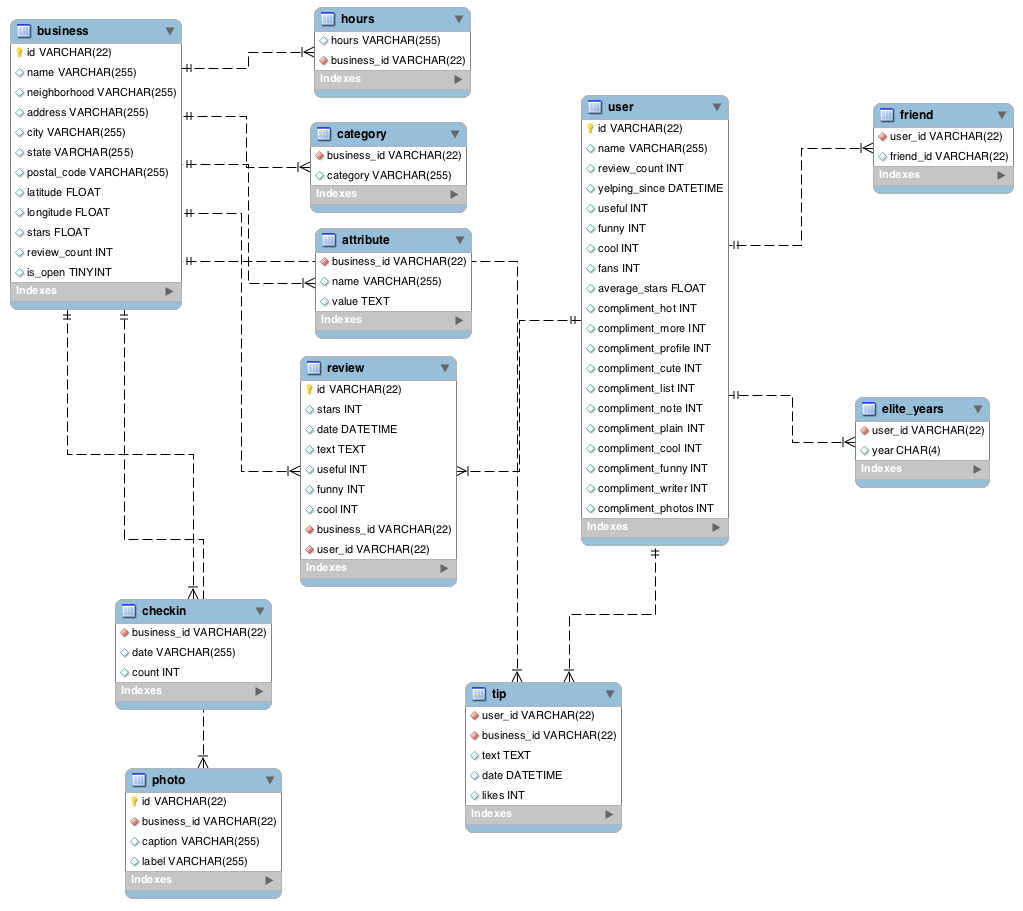

In [30]:
Image("https://s3-media2.fl.yelpcdn.com/assets/srv0/engineering_pages/9c5f7a89fd08/assets/img/dataset/yelp_dataset_schema.png")

Reviews, Users, Business and Categories are the most important datasets for us to build the model

# Data Pre-Processing

The next series of steps will include merging the dataframes to get all the needed elements in one dataframe. The merge will include the following steps 

1. Merging the Reviews and the Business  dataframe 
2. Merging the Users dataframe with the dataframe in step #1. 
3. Merging the categories with the dataframe in step #2. 


## Step 1 Merge: Reviews and Business

### Renaming Columns in the Business Dataframe

In [31]:
'''Renaming the column names in the Business Dataframes before the Merge '''

business_df.rename(columns={'id': 'business_id', 'name': 'business_name', 'address': 'business_address',\
                            'city': 'business_city', 'state': 'business_state',\
                            'postal_code': 'business_postal_code' , 'stars': 'business_stars',\
                            'review_count': 'business_review_count', 'is_open': 'business_isopen'}, inplace=True)

In [32]:
'''Reviewing the list of column names in the Business Dataframe'''

business_df.columns

Index(['business_id', 'business_name', 'neighborhood', 'business_address', 'business_city', 'business_state', 'business_postal_code', 'latitude', 'longitude', 'business_stars', 'business_review_count', 'business_isopen'], dtype='object')

### Renaming Columns in the Review Dataframe

In [33]:
'''Renaming the column names in the Review Dataframes before the Merge '''

review_df.rename(columns={'id': 'review_id', 'stars': 'review_stars', 'date': 'review_date',\
                          'text': 'review_text', 'useful': 'review_useful', 'funny': 'review_funny',\
                          'cool': 'review_cool'}, inplace = True)

In [43]:
'''Reviewing the list of columns in the Review Dataframe'''

review_df.columns

Index(['review_id', 'review_stars', 'review_date', 'review_text', 'review_useful', 'review_funny', 'review_cool', 'business_id', 'user_id'], dtype='object')

### Merge

In [44]:
'''Merging the Reviews and the Business Dataframes'''

review_business = pd.merge(review_df, business_df, on='business_id' )

In [45]:
review_business.head()

,review_id,review_stars,review_date,review_text,review_useful,review_funny,review_cool,business_id,user_id,business_name,neighborhood,business_address,business_city,business_state,business_postal_code,latitude,longitude,business_stars,business_review_count,business_isopen
0,----X0BIDP9tA49U3RvdSQ,4,2014-02-17,"Red, white and bleu salad was super yum and a ...",0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,gVmUR8rqUFdbSeZbsg6z_w,Red Robin Gourmet Burgers,,10240 W McDowell Road,Avondale,AZ,85323,33.4652,-112.281,3.0,104,1
1,-xWKdp-WwOqH0wmgRRUDAw,5,2015-10-12,I love this place. I worked at Red Robin 15 ye...,0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,1RfYkPg_zadobGQyGvv_sA,Red Robin Gourmet Burgers,,10240 W McDowell Road,Avondale,AZ,85323,33.4652,-112.281,3.0,104,1
2,09uUEX7YK9DGqpZOVlZhMA,3,2013-05-17,Dear Yelp... half stars....pleeeeeeease!\n\nAn...,0,2,0,Ue6-WhXvI-_1xUIuapl0zQ,hh2jrSklEfM9Dw5q3rxP3g,Red Robin Gourmet Burgers,,10240 W McDowell Road,Avondale,AZ,85323,33.4652,-112.281,3.0,104,1
3,0SejaV1xUpswVYIZKhW0vA,2,2016-03-26,Today would be my third time ever eating at a ...,0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,Y1CHpv6YJ6hNXVNTjcM6Mw,Red Robin Gourmet Burgers,,10240 W McDowell Road,Avondale,AZ,85323,33.4652,-112.281,3.0,104,1
4,1XC3dV9lzobiN3ZWZevP6Q,4,2017-02-18,"Sometimes you just want an good burger, or at ...",0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,FJH32jg-8ZKIrZLPfZX_Ww,Red Robin Gourmet Burgers,,10240 W McDowell Road,Avondale,AZ,85323,33.4652,-112.281,3.0,104,1


In [46]:
print ('Shape of Review Dataframe: ',  review_df.shape)

print ('Shape of Business Dataframe: ',  business_df.shape)

print ('Shape of Review Business Dataframe: ',  review_business.shape)

Shape of Review Dataframe:  (4736897, 9)
Shape of Business Dataframe:  (156639, 12)
Shape of Review Business Dataframe:  (4736897, 20)


We are able to confirm that the number of rows in the original reviews dataframe and the merged reviews dataframe is the same.

## Step 2 Merge: Review, Business and Users 

### Renaming the columns in the Users Dataframe

In [47]:
user_df.rename(columns={'id': 'user_id', 'name': 'user_name', 'review_count': 'user_review_count',\
                       'yelping_since': 'user_yelping_since'}, inplace=True)

In [48]:
user_df_short = user_df[['user_id', 'user_name', 'user_review_count', 'user_yelping_since']]
# user_df_short['user_id_name'] = user_df_short['user_name'] + user_df_short['user_id']
user_df_short.head()

,user_id,user_name,user_review_count,user_yelping_since
0,---1lKK3aKOuomHnwAkAow,Monera,245,2007-06-04
1,---94vtJ_5o_nikEs6hUjg,Joe,2,2016-05-27
2,---cu1hq55BP9DWVXXKHZg,Jeb,57,2009-04-18
3,---fhiwiwBYrvqhpXgcWDQ,Jed,8,2011-04-20
4,---PLwSf5gKdIoVnyRHgBA,Rae,2,2015-07-31


# Merge

In [49]:
'''Merging the Review_Business and Users Dataframes'''

review_business_users = pd.merge(review_business, user_df_short, on= 'user_id')

In [50]:
review_business_users.head()

,review_id,review_stars,review_date,review_text,review_useful,review_funny,review_cool,business_id,user_id,business_name,neighborhood,business_address,business_city,business_state,business_postal_code,latitude,longitude,business_stars,business_review_count,business_isopen,user_name,user_review_count,user_yelping_since
0,----X0BIDP9tA49U3RvdSQ,4,2014-02-17,"Red, white and bleu salad was super yum and a ...",0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,gVmUR8rqUFdbSeZbsg6z_w,Red Robin Gourmet Burgers,,10240 W McDowell Road,Avondale,AZ,85323,33.4652,-112.281,3.0,104,1,Beth,484,2009-01-02
1,Ch464kMu7MGRg-Xvb3j2aw,3,2012-08-29,"I'm not sure which came first, Postino's or St...",3,2,0,z6-reuC5BYf_Rth9gMBfgQ,gVmUR8rqUFdbSeZbsg6z_w,St. Francis Restaurant,,111 E Camelback Rd,Phoenix,AZ,85012,33.5090,-112.071,4.0,1273,1,Beth,484,2009-01-02
2,LhUiilxYwQDzaKI5oFnkBw,5,2011-12-14,Wow. and I'll say it again. Wow. I felt like s...,0,0,0,5LNZ67Yw9RD6nf4_UhXOjw,gVmUR8rqUFdbSeZbsg6z_w,The Cosmopolitan of Las Vegas,The Strip,3708 Las Vegas Blvd S,Las Vegas,NV,89109,36.1097,-115.174,4.0,3621,1,Beth,484,2009-01-02
3,moMY7HlKwk9HWgACnty_cQ,4,2012-08-29,Unique and fun new place in Scottsdale! Took t...,0,0,0,OY0-hYJ2q6WiAqhYnCZZ0w,gVmUR8rqUFdbSeZbsg6z_w,Brat Haus,,3622 N Scottsdale Rd,Scottsdale,AZ,85251,33.4900,-111.926,4.0,587,1,Beth,484,2009-01-02
4,bOOTnO1PeKJ6ms3-b8sWSA,5,2015-12-27,Wow. \n\nFor quite a long time I've avoided Pi...,2,1,1,pSQFynH1VxkfSmehRXlZWw,gVmUR8rqUFdbSeZbsg6z_w,Pizzeria Bianco,,623 E Adams St,Phoenix,AZ,85004,33.4492,-112.066,4.0,1899,1,Beth,484,2009-01-02


In [51]:
review_business_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4736897 entries, 0 to 4736896
Data columns (total 23 columns):
review_id                object
review_stars             int64
review_date              datetime64[ns]
review_text              object
review_useful            int64
review_funny             int64
review_cool              int64
business_id              object
user_id                  object
business_name            object
neighborhood             object
business_address         object
business_city            object
business_state           object
business_postal_code     object
latitude                 float64
longitude                float64
business_stars           float64
business_review_count    int64
business_isopen          int64
user_name                object
user_review_count        int64
user_yelping_since       datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(7), object(11)
memory usage: 867.4+ MB


In [52]:
print ('Shape of Review Dataframe: ',  review_df.shape)

print ('Shape of Business Dataframe: ',  business_df.shape)

print ('Shape of Users Dataframe: ', user_df.shape)

print ('Shape of Review Business Users Dataframe: ',  review_business_users.shape)

Shape of Review Dataframe:  (4736897, 9)
Shape of Business Dataframe:  (156639, 12)
Shape of Users Dataframe:  (1183362, 20)
Shape of Review Business Users Dataframe:  (4736897, 23)


The number of rows in the original reviews dataframe is the same as the number of rows in the merged reviews dataframe

## Step 3 Merge: Review, Business, Users and Categories 

We have already seen the dataset has a large number of categories. For the purposes of this project we are only going to look into the Restaurant category

### Renaming the columns in the Categories Dataframe 

In [53]:
category_df.rename(columns={'category': 'category_name'}, inplace=True)

### Extracting the list of Restaurant Categories only

In [54]:
restaurant_category = category_df.loc[category_df['category_name'] == 'Restaurants',:]

In [55]:
restaurant_category.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51613 entries, 5 to 590279
Data columns (total 2 columns):
business_id      51613 non-null object
category_name    51613 non-null object
dtypes: object(2)
memory usage: 1.2+ MB


The dataset has close to 51k businesses that are listed as restaurants

In [56]:
restaurant_category.head()

,business_id,category_name
5,mLwM-h2YhXl2NCgdS84_Bw,Restaurants
11,duHFBe87uNSXImQmvBh87Q,Restaurants
54,SDMRxmcKPNt1AHPBKqO64Q,Restaurants
59,iFEiMJoEqyB9O8OUNSdLzA,Restaurants
76,HmI9nhgOkrXlUr6KZGZZew,Restaurants


# Merge 

In [57]:
'''Merging the Review_Business_Users and the Category Dataframes'''

review_business_users_category = pd.merge(review_business_users, restaurant_category, on = 'business_id')

In [58]:
review_business_users_category.head()

,review_id,review_stars,review_date,review_text,review_useful,review_funny,review_cool,business_id,user_id,business_name,neighborhood,business_address,business_city,business_state,business_postal_code,latitude,longitude,business_stars,business_review_count,business_isopen,user_name,user_review_count,user_yelping_since,category_name
0,----X0BIDP9tA49U3RvdSQ,4,2014-02-17,"Red, white and bleu salad was super yum and a ...",0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,gVmUR8rqUFdbSeZbsg6z_w,Red Robin Gourmet Burgers,,10240 W McDowell Road,Avondale,AZ,85323,33.4652,-112.281,3.0,104,1,Beth,484,2009-01-02,Restaurants
1,-xWKdp-WwOqH0wmgRRUDAw,5,2015-10-12,I love this place. I worked at Red Robin 15 ye...,0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,1RfYkPg_zadobGQyGvv_sA,Red Robin Gourmet Burgers,,10240 W McDowell Road,Avondale,AZ,85323,33.4652,-112.281,3.0,104,1,Jon,24,2015-09-13,Restaurants
2,09uUEX7YK9DGqpZOVlZhMA,3,2013-05-17,Dear Yelp... half stars....pleeeeeeease!\n\nAn...,0,2,0,Ue6-WhXvI-_1xUIuapl0zQ,hh2jrSklEfM9Dw5q3rxP3g,Red Robin Gourmet Burgers,,10240 W McDowell Road,Avondale,AZ,85323,33.4652,-112.281,3.0,104,1,Miss,138,2010-06-02,Restaurants
3,0SejaV1xUpswVYIZKhW0vA,2,2016-03-26,Today would be my third time ever eating at a ...,0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,Y1CHpv6YJ6hNXVNTjcM6Mw,Red Robin Gourmet Burgers,,10240 W McDowell Road,Avondale,AZ,85323,33.4652,-112.281,3.0,104,1,Vee,40,2014-12-23,Restaurants
4,1XC3dV9lzobiN3ZWZevP6Q,4,2017-02-18,"Sometimes you just want an good burger, or at ...",0,0,0,Ue6-WhXvI-_1xUIuapl0zQ,FJH32jg-8ZKIrZLPfZX_Ww,Red Robin Gourmet Burgers,,10240 W McDowell Road,Avondale,AZ,85323,33.4652,-112.281,3.0,104,1,Tim,228,2007-05-28,Restaurants


In [59]:
'''Reviewing the final set of columns that is in our merged dataframe'''

review_business_users_category.columns

Index(['review_id', 'review_stars', 'review_date', 'review_text', 'review_useful', 'review_funny', 'review_cool', 'business_id', 'user_id', 'business_name', 'neighborhood', 'business_address', 'business_city', 'business_state', 'business_postal_code', 'latitude', 'longitude', 'business_stars', 'business_review_count', 'business_isopen', 'user_name', 'user_review_count', 'user_yelping_since', 'category_name'], dtype='object')

On quick review we notice a few important columns like review_stars, user_name, business_name, business_state, business_city.  

In [60]:
review_business_users_category.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927731 entries, 0 to 2927730
Data columns (total 24 columns):
review_id                object
review_stars             int64
review_date              datetime64[ns]
review_text              object
review_useful            int64
review_funny             int64
review_cool              int64
business_id              object
user_id                  object
business_name            object
neighborhood             object
business_address         object
business_city            object
business_state           object
business_postal_code     object
latitude                 float64
longitude                float64
business_stars           float64
business_review_count    int64
business_isopen          int64
user_name                object
user_review_count        int64
user_yelping_since       datetime64[ns]
category_name            object
dtypes: datetime64[ns](2), float64(3), int64(7), object(12)
memory usage: 558.4+ MB


In [61]:
print ('Shape of Review Dataframe: ',  review_df.shape)

print ('Shape of Review Business Users Dataframe: ',  review_business_users_category.shape)

Shape of Review Dataframe:  (4736897, 9)
Shape of Review Business Users Dataframe:  (2927731, 24)


Note: We see that there is a huge drop in number of reviews in the final merged dataframe as compared to the original reviews dataframe. On further review I noticed that not all businesses in the reviews dataframe had a corresponding category in the categories dataframe. Hence a good set of the reviews got dropped in the process. 

That said, for the purposes of the analysis we are going to proceed with the merged dataset for a couple of reasons 

1. The reviews consists of reviews for all kinds of businesses. As we are building out a recommeder system to recommend users we need to distinguish them using the category == 'Restaurant' 
2. The risk of not doing the above step is users getting recommendation for businesses across categories. E.g. Based on the recommendations provided by a users on restaurants, they may get a recommendation for a Hair Salon, moving companies 

While we do loose some data, we have a decent size data to build and test our model

### Performing some quick EDA to see the list of States in the dataset 

In [62]:
review_business_users_category['business_state'].value_counts()

NV     949900
AZ     837240
ON     414444
NC     180619
OH     154764
PA     143304
QC      98967
WI      69055
BW      24935
EDH     23751
IL      22193
SC       5981
MLN      1101
HLD       588
C         168
ELN       117
FIF       110
NYK       101
WLN        87
NY         73
NI         58
WA         39
ST         24
01         24
PKN        24
ESX        11
BY         10
RCC         7
KHL         7
XGL         6
3           5
WHT         4
CA          4
HH          4
ZET         3
ABE         3
Name: business_state, dtype: int64

We see that the top states that have reviews are NV, AZ, and OH. 

For the purposes of building out the initial model we are going to extract out the restaurants in the state of South Carolina alone. i.e. (business_state == 'SC'). This gives us a smaller yet managable dataset to build out a model before expanding the scope of the model. 

There is close to 5k reviews associated in the state of SC

# Extracting the Restaurants in the state of SC

In [63]:
review_sc = review_business_users_category.loc[review_business_users_category['business_state']  == 'SC', :]

#### Reviewing the number of restaurants in the selected area

In [64]:
'''Validating the number of restaurants in the WI area'''
print ('Total Number of Restaurants in the selected Dataset: ', len(review_sc.business_name.unique()))

Total Number of Restaurants in the selected Dataset:  174


In [65]:
'''List of 100 Restaurants in the selected Dataset'''
list(review_sc.business_name.unique())[0:100]

['The Flipside Cafe',
 'Lee Cafe',
 'Hwy 55 Burgers Shakes & Fries',
 "Di-Dee's Diner",
 "Madison's On the Corner",
 'Fish Market',
 'Mamas Pizza & Pasta',
 "Rizzo's Spaghetti House",
 'Hickory Tavern',
 "Brew's Tavern",
 '521 BBQ & Grill',
 'Six Pence Pub',
 "Salsarita's Fresh Mexican Grill",
 'Freebirds Family Restaurant',
 'Akahana - Asian Bistro, Bar & Sushi',
 'Tapas 51',
 'Blacow Burger',
 'Passion8 Bistro',
 "Culver's",
 "Papa Pino's",
 'Famous Toastery',
 'Local Dish',
 "Hobo's",
 'Fort Mill BBQ Company',
 "Zaxby's Chicken Fingers & Buffalo Wings",
 'Subway',
 "Hardee's of Fort Mill",
 'The Mill Eatery & Drafthouse',
 'Charanda Mexican Grill & Cantina',
 'Burger Craft',
 'Patriot Taphouse and Grill',
 'Empire Pizza & Bar',
 'American Cafe & Lounge',
 'City Tavern',
 'Cloud 9 Martini & Tapas Bar',
 'Taqueria La Unica',
 'Shia Asian Bistro',
 "Jim 'N Nick's Bar-B-Q",
 'Chinatown',
 'Cracker Barrel Old Country Store',
 'Hanako',
 'Wing King Cafe',
 'KFC',
 'Sweetwater Sports Bar &

#### Reviewing the list of reviews in the dataset 

In [66]:
'''Validating the number of reviews'''
print ('Total Number of reviews in the selected Dataset: ', len(review_sc.review_id.unique()))

Total Number of reviews in the selected Dataset:  5981


Now that we have the data in a decent shape and form, we can start of by building out a simple model. One of the simpler models with recommender systems is the collaborative filtering model. However the first step is to build out a sparse matrix

# Creating the Sparse Matrix for Collaborative Filtering

In [67]:
sparse_m = review_sc.pivot_table(index='user_id', columns='business_name', values='review_stars')

In [68]:
'''Replacing the spaces in the column names with the underscore _'''

sparse_m.columns = sparse_m.columns.str.replace(' ', '_')
sparse_m.columns = sparse_m.columns.str.replace("'", '-')
sparse_m.columns = sparse_m.columns.str.replace(",", '-')

In [69]:
'''Reviewing the first 20 columns in the sparse matrix'''
sparse_m.head(10)

business_name,521_BBQ_&_Grill,Akahana_-_Asian_Bistro-_Bar_&_Sushi,American_Cafe_&_Lounge,Angelos_of_Fort_Mill,Arby-s,Archie_Boy-s_BBQ,Asian_Express,Asian_Roll_&_Grill,Bacintyme_Coffee_Cafe,Bagel_Boat,Bavarian_Deli,Baxter_Social_House,Beef_-O-_Brady-s,Bert-s_Backyard_Bar_and_Bistro,Best_China,Big_Apple_Bagels,Big_Wok,Bistro_160_Cafe_&_Catering,Blacow_Burger,Blue_Heron_Grill,Bojangles,Bojangles_Restaurant,Bojangles-_Famous_Chicken_-n_Biscuits,Bravo_Antonio,Bravo_Restaurant,Brew-s_Tavern,Brixx_Wood_Fired_Pizza,Burger_Craft,Burger_King,Captain_Steve-s,Carlos_Cafe,Carmellas_Pizza_Grill,Carolina_Ale_House,Carolina_Creamery,Casa_Colombia,Casual_Water,Charanda_Mexican_Grill_&_Cantina,Cherry,Cherry_Sushi_&_Grill,Chick-fil-A,China_East,China_II,China_Inn,Chinatown,City_Tavern,Cloud_9_Martini_&_Tapas_Bar,Cracker_Barrel_Old_Country_Store,Cruzin_Reubenz_by_Phil-s_Deli,Culver-s,Dairy_Queen,Danny-s_Pizza,Danny-s_Pizza_and_Pasta,De_Marco-s_Italian_Grill,Di-Dee-s_Diner,Digby-s_Pizza,Domino-s_Pizza,Drunken_Goat_Bar_&_Grill,E&J-s_Pit_Beef,Eat_Well,El_Cancun_Mexican_Restaurant,El_Maguey,Empire_Pizza_&_Bar,Esposito-s_Pizzeria_Bagels,Famous_Toastery,Figaro-s_Pizza,Fish_Market,Fort_Mill_BBQ_Company,Fort_Mill_Family_Restaurant,Fratelli_Ristorante_&_Pizzeria,Freebirds_Family_Restaurant,Golden_China,Greco_Fresh_Grille,Groucho-s_Deli,Hanako,Hardee-s_Red_Burrito,Hardee-s_of_Fort_Mill,Hickory_Tavern,Hobo-s,Hwy_55_Burgers_Shakes_&_Fries,Jersey_Mike-s_Subs,Jerusalem_Cafe,Jim_-N_Nick-s_Bar-B-Q,Jimmy_John-s,John-s_Place,Johnny_K_Restaurant,Jumpin-_Java,KFC,La_Fornarina,La_Poblanita_Market_and_Grill,Ladles,Lee_Cafe,Lee-s_Hoagie_House,Little_Caesars_Pizza,Liu_Lius_Asian_Bistro,Local_Dish,Long_John_Silver-s,Los_Aztecas,Madison-s_On_the_Corner,Mama_Theresa-s,Mamas_Pizza_&_Pasta,Marco-s_Pizza,Market_Street_Pizza,McAlister-s_Deli,McDonald-s,McHale-s,Midtown_Sundries_Grill_&_Bar,Moe-s_Southwest_Grill,Mulligans_Sports_Bar_&_Grille,Ocean_Palace,Panda_Hut,Panera_Bread,Papa_John-s_Pizza,Papa_Murphy-s,Papa_Pino-s,Pasquale-s_Restaurant_&_Pub,Passion8_Bistro,Patriot_Taphouse_and_Grill,Peking_Tokyo,Pelican-s_SnoBalls,Pizza_Hut,Plaza_Fiesta_Carolinas,Q2U_BBQ_Pit_and_Catering,QuikTrip,RC-s_Grill_&_Sandbar,Rainbow_Asian_Bistro,Reagan-s_Public_House,Red_Bowl,Regent_Park_Cafe,Rizzo-s_Spaghetti_House,Roasting_Oven_&_Grill,Saiki_Japanese_Restaurant,Sal-s_Roadside_Eatery,Salsarita-s_Fresh_Mexican_Grill,Savannah-s,Shane-s_Rib_Shack,Shia_Asian_Bistro,Showmars_Fort_Mill-Hwy_521,Six_Pence_Pub,Skyline_Grille_at_Regent_Park_Golf_Club,Small_Bar_Fort_Mill,Smoothie_King,Southern_Salads_&_Sandwich_Company,Steve_and_Kelly-s_Grill_House,Sub_Station_II,Subway,Sweet_Peppers_Deli,Sweetwater_Sports_Bar_&_Grill,T-Bones_On_the_Lake,Taco_Bell,Tacos_Nayarit_#2,Tapas_51,Taqueria_La_Unica,Tega_Cay_Golf_and_Community_Center,Tega_Cay_Gourmet_Deli,Tenders,The_Carolina_Bistro,The_Flipside_Cafe,The_Mill_Eatery_&_Drafthouse,The_River_Rat,The_Roasting_Oven,The_Shore_Club,Tian_Tian_Asian_Restaurant,Toast_Cafe,Toppers_Pizza,Towne_Tavern,Trifecta_Grill,Tropical_Smoothie_Cafe,Twin_Rivers,Village_Pizza,Waffle_House,Wendy-s,Wing_King_Cafe,WingBonz,Zaxby-s_Chicken_Fingers_&_Buffalo_Wings
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--44NNdtngXMzsxyN7ju6Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

We clearly see that this matrix is a very sparse matrix, with a lot of null values in them. 

Wiki link on sparse matrix: https://en.wikipedia.org/wiki/Sparse_matrix

In [70]:
'''Checking the shape of sparse matrix'''
sparse_m.shape

(3450, 174)

The shape tells us that there are 3193 users and 174 restaurants

In [71]:
'''Updating the NAN columns with 0s'''

sparse_m.fillna(0, inplace=True)
sparse_m.head()

business_name,521_BBQ_&_Grill,Akahana_-_Asian_Bistro-_Bar_&_Sushi,American_Cafe_&_Lounge,Angelos_of_Fort_Mill,Arby-s,Archie_Boy-s_BBQ,Asian_Express,Asian_Roll_&_Grill,Bacintyme_Coffee_Cafe,Bagel_Boat,Bavarian_Deli,Baxter_Social_House,Beef_-O-_Brady-s,Bert-s_Backyard_Bar_and_Bistro,Best_China,Big_Apple_Bagels,Big_Wok,Bistro_160_Cafe_&_Catering,Blacow_Burger,Blue_Heron_Grill,Bojangles,Bojangles_Restaurant,Bojangles-_Famous_Chicken_-n_Biscuits,Bravo_Antonio,Bravo_Restaurant,Brew-s_Tavern,Brixx_Wood_Fired_Pizza,Burger_Craft,Burger_King,Captain_Steve-s,Carlos_Cafe,Carmellas_Pizza_Grill,Carolina_Ale_House,Carolina_Creamery,Casa_Colombia,Casual_Water,Charanda_Mexican_Grill_&_Cantina,Cherry,Cherry_Sushi_&_Grill,Chick-fil-A,China_East,China_II,China_Inn,Chinatown,City_Tavern,Cloud_9_Martini_&_Tapas_Bar,Cracker_Barrel_Old_Country_Store,Cruzin_Reubenz_by_Phil-s_Deli,Culver-s,Dairy_Queen,Danny-s_Pizza,Danny-s_Pizza_and_Pasta,De_Marco-s_Italian_Grill,Di-Dee-s_Diner,Digby-s_Pizza,Domino-s_Pizza,Drunken_Goat_Bar_&_Grill,E&J-s_Pit_Beef,Eat_Well,El_Cancun_Mexican_Restaurant,El_Maguey,Empire_Pizza_&_Bar,Esposito-s_Pizzeria_Bagels,Famous_Toastery,Figaro-s_Pizza,Fish_Market,Fort_Mill_BBQ_Company,Fort_Mill_Family_Restaurant,Fratelli_Ristorante_&_Pizzeria,Freebirds_Family_Restaurant,Golden_China,Greco_Fresh_Grille,Groucho-s_Deli,Hanako,Hardee-s_Red_Burrito,Hardee-s_of_Fort_Mill,Hickory_Tavern,Hobo-s,Hwy_55_Burgers_Shakes_&_Fries,Jersey_Mike-s_Subs,Jerusalem_Cafe,Jim_-N_Nick-s_Bar-B-Q,Jimmy_John-s,John-s_Place,Johnny_K_Restaurant,Jumpin-_Java,KFC,La_Fornarina,La_Poblanita_Market_and_Grill,Ladles,Lee_Cafe,Lee-s_Hoagie_House,Little_Caesars_Pizza,Liu_Lius_Asian_Bistro,Local_Dish,Long_John_Silver-s,Los_Aztecas,Madison-s_On_the_Corner,Mama_Theresa-s,Mamas_Pizza_&_Pasta,Marco-s_Pizza,Market_Street_Pizza,McAlister-s_Deli,McDonald-s,McHale-s,Midtown_Sundries_Grill_&_Bar,Moe-s_Southwest_Grill,Mulligans_Sports_Bar_&_Grille,Ocean_Palace,Panda_Hut,Panera_Bread,Papa_John-s_Pizza,Papa_Murphy-s,Papa_Pino-s,Pasquale-s_Restaurant_&_Pub,Passion8_Bistro,Patriot_Taphouse_and_Grill,Peking_Tokyo,Pelican-s_SnoBalls,Pizza_Hut,Plaza_Fiesta_Carolinas,Q2U_BBQ_Pit_and_Catering,QuikTrip,RC-s_Grill_&_Sandbar,Rainbow_Asian_Bistro,Reagan-s_Public_House,Red_Bowl,Regent_Park_Cafe,Rizzo-s_Spaghetti_House,Roasting_Oven_&_Grill,Saiki_Japanese_Restaurant,Sal-s_Roadside_Eatery,Salsarita-s_Fresh_Mexican_Grill,Savannah-s,Shane-s_Rib_Shack,Shia_Asian_Bistro,Showmars_Fort_Mill-Hwy_521,Six_Pence_Pub,Skyline_Grille_at_Regent_Park_Golf_Club,Small_Bar_Fort_Mill,Smoothie_King,Southern_Salads_&_Sandwich_Company,Steve_and_Kelly-s_Grill_House,Sub_Station_II,Subway,Sweet_Peppers_Deli,Sweetwater_Sports_Bar_&_Grill,T-Bones_On_the_Lake,Taco_Bell,Tacos_Nayarit_#2,Tapas_51,Taqueria_La_Unica,Tega_Cay_Golf_and_Community_Center,Tega_Cay_Gourmet_Deli,Tenders,The_Carolina_Bistro,The_Flipside_Cafe,The_Mill_Eatery_&_Drafthouse,The_River_Rat,The_Roasting_Oven,The_Shore_Club,Tian_Tian_Asian_Restaurant,Toast_Cafe,Toppers_Pizza,Towne_Tavern,Trifecta_Grill,Tropical_Smoothie_Cafe,Twin_Rivers,Village_Pizza,Waffle_House,Wendy-s,Wing_King_Cafe,WingBonz,Zaxby-s_Chicken_Fingers_&_Buffalo_Wings
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--44NNdtngXMzsxyN7ju6Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [72]:
'''Top 20 Most Recommended Business'''
sparse_m.sum().sort_values(ascending=False)[0:20]

business_name
The_Flipside_Cafe                      1308.0
Local_Dish                             1045.0
521_BBQ_&_Grill                         777.5
Famous_Toastery                         638.5
Hobo-s                                  629.0
Captain_Steve-s                         603.0
Lee_Cafe                                460.0
Fish_Market                             407.0
Blacow_Burger                           402.0
Peking_Tokyo                            342.0
Tapas_51                                342.0
Akahana_-_Asian_Bistro-_Bar_&_Sushi     334.0
T-Bones_On_the_Lake                     332.0
Danny-s_Pizza_and_Pasta                 329.0
Six_Pence_Pub                           324.0
Culver-s                                315.0
Red_Bowl                                287.0
Sweetwater_Sports_Bar_&_Grill           274.0
Empire_Pizza_&_Bar                      269.0
Passion8_Bistro                         267.0
dtype: float64

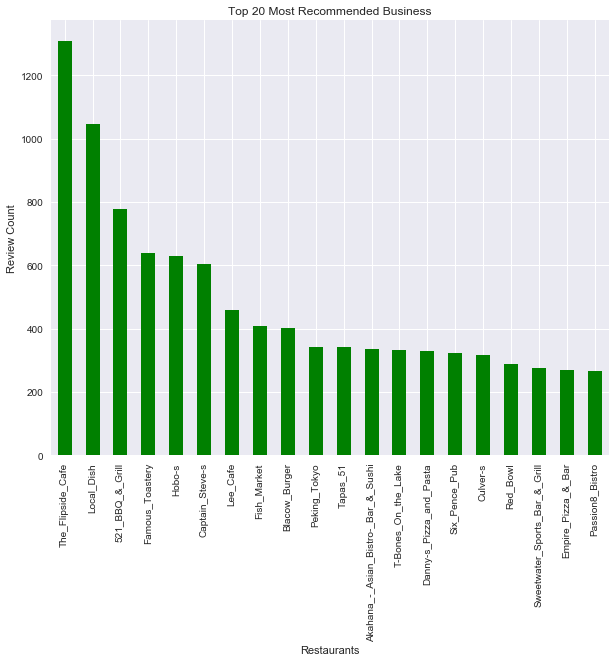

In [73]:
'''Top 20 Most Recommended Restaurants'''
sparse_m.sum().sort_values(ascending=False)[0:20].plot(kind='bar', color='g', figsize = (10,8))
plt.title('Top 20 Most Recommended Business')
plt.xlabel('Restaurants')
plt.ylabel('Review Count')

# Model Building

The model building for this capstone focusses primarily on two main approaches 

* **Collaborative Filtering**

 * **Item - Item Filtering:** This approach focusses on comparing the items themselves to see how similar they are to each other (based on ratings provided by the user), and provides a recommendation based on item similarity. 
 * **User - User Filtering:** This approach focusses on comparing users among each other to see how similar they are to one another, and provides a recommendation based on user similarity. 
 
Both the Item-Item filtering and the User-User filtering focusses heavily on the User-Item sparse matrix to churn through the logic and to make predictions

* **Content Based Filtering**: This approach focusses on comparing the attributes of the items (e.g. Parking, Lighting, Service, Music), and identifies items that are similar and provides the recommendations to users based on item attributes. 


Overall the assumption has been that the content based filtering model performs better than the Collaborative Filtering model. It also partially handles the cold start problem. The other approaches include a hybrid model. 



#### Setting up the inputs for the model 

In [74]:
'''Assigning the sparse matrix to a new variable'''
restaurants_df = sparse_m

In [75]:
restaurants_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3450 entries, --44NNdtngXMzsxyN7ju6Q to zyK_lHnOYAZFUY2I9Q7YjA
Columns: 174 entries, 521_BBQ_&_Grill to Zaxby-s_Chicken_Fingers_&_Buffalo_Wings
dtypes: float64(174)
memory usage: 4.6+ MB


In [76]:
restaurants_df.head()

business_name,521_BBQ_&_Grill,Akahana_-_Asian_Bistro-_Bar_&_Sushi,American_Cafe_&_Lounge,Angelos_of_Fort_Mill,Arby-s,Archie_Boy-s_BBQ,Asian_Express,Asian_Roll_&_Grill,Bacintyme_Coffee_Cafe,Bagel_Boat,Bavarian_Deli,Baxter_Social_House,Beef_-O-_Brady-s,Bert-s_Backyard_Bar_and_Bistro,Best_China,Big_Apple_Bagels,Big_Wok,Bistro_160_Cafe_&_Catering,Blacow_Burger,Blue_Heron_Grill,Bojangles,Bojangles_Restaurant,Bojangles-_Famous_Chicken_-n_Biscuits,Bravo_Antonio,Bravo_Restaurant,Brew-s_Tavern,Brixx_Wood_Fired_Pizza,Burger_Craft,Burger_King,Captain_Steve-s,Carlos_Cafe,Carmellas_Pizza_Grill,Carolina_Ale_House,Carolina_Creamery,Casa_Colombia,Casual_Water,Charanda_Mexican_Grill_&_Cantina,Cherry,Cherry_Sushi_&_Grill,Chick-fil-A,China_East,China_II,China_Inn,Chinatown,City_Tavern,Cloud_9_Martini_&_Tapas_Bar,Cracker_Barrel_Old_Country_Store,Cruzin_Reubenz_by_Phil-s_Deli,Culver-s,Dairy_Queen,Danny-s_Pizza,Danny-s_Pizza_and_Pasta,De_Marco-s_Italian_Grill,Di-Dee-s_Diner,Digby-s_Pizza,Domino-s_Pizza,Drunken_Goat_Bar_&_Grill,E&J-s_Pit_Beef,Eat_Well,El_Cancun_Mexican_Restaurant,El_Maguey,Empire_Pizza_&_Bar,Esposito-s_Pizzeria_Bagels,Famous_Toastery,Figaro-s_Pizza,Fish_Market,Fort_Mill_BBQ_Company,Fort_Mill_Family_Restaurant,Fratelli_Ristorante_&_Pizzeria,Freebirds_Family_Restaurant,Golden_China,Greco_Fresh_Grille,Groucho-s_Deli,Hanako,Hardee-s_Red_Burrito,Hardee-s_of_Fort_Mill,Hickory_Tavern,Hobo-s,Hwy_55_Burgers_Shakes_&_Fries,Jersey_Mike-s_Subs,Jerusalem_Cafe,Jim_-N_Nick-s_Bar-B-Q,Jimmy_John-s,John-s_Place,Johnny_K_Restaurant,Jumpin-_Java,KFC,La_Fornarina,La_Poblanita_Market_and_Grill,Ladles,Lee_Cafe,Lee-s_Hoagie_House,Little_Caesars_Pizza,Liu_Lius_Asian_Bistro,Local_Dish,Long_John_Silver-s,Los_Aztecas,Madison-s_On_the_Corner,Mama_Theresa-s,Mamas_Pizza_&_Pasta,Marco-s_Pizza,Market_Street_Pizza,McAlister-s_Deli,McDonald-s,McHale-s,Midtown_Sundries_Grill_&_Bar,Moe-s_Southwest_Grill,Mulligans_Sports_Bar_&_Grille,Ocean_Palace,Panda_Hut,Panera_Bread,Papa_John-s_Pizza,Papa_Murphy-s,Papa_Pino-s,Pasquale-s_Restaurant_&_Pub,Passion8_Bistro,Patriot_Taphouse_and_Grill,Peking_Tokyo,Pelican-s_SnoBalls,Pizza_Hut,Plaza_Fiesta_Carolinas,Q2U_BBQ_Pit_and_Catering,QuikTrip,RC-s_Grill_&_Sandbar,Rainbow_Asian_Bistro,Reagan-s_Public_House,Red_Bowl,Regent_Park_Cafe,Rizzo-s_Spaghetti_House,Roasting_Oven_&_Grill,Saiki_Japanese_Restaurant,Sal-s_Roadside_Eatery,Salsarita-s_Fresh_Mexican_Grill,Savannah-s,Shane-s_Rib_Shack,Shia_Asian_Bistro,Showmars_Fort_Mill-Hwy_521,Six_Pence_Pub,Skyline_Grille_at_Regent_Park_Golf_Club,Small_Bar_Fort_Mill,Smoothie_King,Southern_Salads_&_Sandwich_Company,Steve_and_Kelly-s_Grill_House,Sub_Station_II,Subway,Sweet_Peppers_Deli,Sweetwater_Sports_Bar_&_Grill,T-Bones_On_the_Lake,Taco_Bell,Tacos_Nayarit_#2,Tapas_51,Taqueria_La_Unica,Tega_Cay_Golf_and_Community_Center,Tega_Cay_Gourmet_Deli,Tenders,The_Carolina_Bistro,The_Flipside_Cafe,The_Mill_Eatery_&_Drafthouse,The_River_Rat,The_Roasting_Oven,The_Shore_Club,Tian_Tian_Asian_Restaurant,Toast_Cafe,Toppers_Pizza,Towne_Tavern,Trifecta_Grill,Tropical_Smoothie_Cafe,Twin_Rivers,Village_Pizza,Waffle_House,Wendy-s,Wing_King_Cafe,WingBonz,Zaxby-s_Chicken_Fingers_&_Buffalo_Wings
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--44NNdtngXMzsxyN7ju6Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [77]:
# restaurants_df.sum(axis = 1)

### Setting up a test user 

In [78]:
user = 'hgWmZXmxG90Zt7Hm0OWqKQ'
# user='-6559fkJ6rCWIZDbqVUomA'

# Popularity Based Recommender - Simple Baseline Model

The popularity based model is one of the most basic forms of recommenders. It looks merely at the popularity of the item based on a set of metrics (e.g. Total Number of Positive Reviews, or ratings above a certain threshold) and recommends the items to the users. 

In [79]:
'''Function to return the most popular Restaurants'''
'''It is a simple function based on the average stars the business has received so far with all the reviews'''

def popular_recommender(df): 
    top_reviewed_series = df.groupby(by='business_name')['business_stars'].max()
    top_reviewed_business= pd.DataFrame(top_reviewed_series)
    top_reviewed_business.sort_values('business_stars', ascending=False, inplace=True)
    return top_reviewed_business  

In [80]:
'''Calling the predictor to make predictions'''

popular_prediction = popular_recommender(review_sc)
popular_prediction.head()

,business_stars
business_name,
Jersey Mike's Subs,5.0
Angelos of Fort Mill,5.0
Archie Boy's BBQ,5.0
Eat Well,5.0
Bavarian Deli,5.0


## Results Interpretation from the Item-Item Collaborative Filtering Model

The popularity based recommender system is probably one of the easiest recommender models. While it is easy to implement a popularity based recommender system with only a few lines of code. The drawback is that the it does not personalize the recommendations for the specific user

# Collaborative Filtering Model (Item v/s Item) 

### Helper Functions - Collaborative Item-Item Filtering

This section has function definitions to 

1. Return the list of restaurants rated by the user 
2. Return the list of restaurants yet to be rated by the user 
3. Calculate the Co-Similarity between either the item vectors or the user vectors 
4. Calculate the co-occurence matrix between the restaurants rated by the user and all other restaurants 
5. Return the restaurants to rate as a dataframe 
6. Return the restaurants already rated as as dataframe

In [81]:
'''Function to return the list of restaurants rated by the user'''

def user_rated_list(user):
    user_rated=[]
    for key, a_res in enumerate(list(restaurants_df.loc[user, :] ==0)):
        if a_res == False:
            user_rated.append((restaurants_df.loc[user, :] ==0).index[key])
        else: 
            continue
    return user_rated  


'''Function to return the list of restaurants yet to be rated by the user'''
def user_not_rated_list(user):
    user_not_rated=[]
    for key, a_res in enumerate(list(restaurants_df.loc[user, :] ==0)):
        if a_res == True:
            user_not_rated.append((restaurants_df.loc[user, :] ==0).index[key])
        else: 
            continue
    return (user_not_rated) 


'''Function to calculate the Co-Similarity'''
def cosim(v1, v2):
    dot_product = sum(n1 * n2 for n1, n2 in zip(v1, v2) )
    magnitude1 = math.sqrt(sum(n ** 2 for n in v1))
    magnitude2 = math.sqrt(sum(n ** 2 for n in v2))
    return dot_product / (magnitude1 * magnitude2)


'''Function to calculate the co-sine similarity between the restaurants rated by the user and all the restaurants in the list'''
def cooccurence_matrix_creator():
    '''Calling the user rated function'''
    user_rated = user_rated_list(user)
    ur_rest_dict = {}
    for ur in user_rated: 
        ur_cosim=[]
        for ar in list(restaurants_df.columns): 
            similarity = cosim(restaurants_df[ur],\
                                            restaurants_df[ar])
            ur_cosim.append(similarity)
        ur_rest_dict[ur] = ur_cosim
    co_occurence_matrix = pd.DataFrame.from_dict(ur_rest_dict, orient='index')
    co_occurence_matrix.columns=list(restaurants_df.columns)
    return co_occurence_matrix

'''Function to create dataframe of the restaurants to be rated'''
def rest_to_rate(cooccurence_df):
    restaurants_to_rate = cooccurence_df[user_not_rated_list(user)]
    return restaurants_to_rate

'''Function to create dataframe of the restaurants to be rated'''
def rest_rated(cooccurence_df):
    restaurants_rated = cooccurence_df[user_rated_list(user)]
    return restaurants_rated

## Main function - Collaborative Item-Item Filtering 

This a the main function definition that inturn calls the helper functions to make prediction for the user restaurants. The approach uses K Nearest Neighbors of 2 to make predictions. In the helper function it also performs some level of SVD to reduce the dimensionality in the vector space 

In [82]:
'''Collaborative Item-Item filtering function to make predictions'''

'''Bugs Fixed in the main dataset run
1. Added condition to handle users who have rated only one restaurant. This was resulting in an index out of bound error.
2. Added logic to handle users who have rated multiple restaurants but the coocurence is non-zero for only on restaurant. 
3. Added logic to handle division by zero in some cases 
''' 


def rating_predictor_colab_ii_all():
    
    predicted_rating_dict = {}
    
    co_occurence_matrix = cooccurence_matrix_creator()
    restaurants_to_rate = rest_to_rate(co_occurence_matrix)
    
    for not_rated in restaurants_to_rate.columns: 
        column_df = pd.DataFrame(restaurants_to_rate[not_rated].sort_values(ascending=False))
        predicted_rating = []
        top_sim_list = []
        if column_df.shape[0] == 1: 
            top_sim = column_df[not_rated]            
            top_sim_list.append(top_sim)

            given_rr = column_df[not_rated].index
            
            given_rank_df = pd.DataFrame(restaurants_df.loc[user, :]) # While converting this to function the name should be an argument to the function
            given_rank = float((given_rank_df.loc[given_rr,:]).get_values())

            adjusted_predicted_rating = float(given_rank*top_sim)
            predicted_rating_dict[not_rated] = adjusted_predicted_rating
             
        else: 
            for top_n in range(2):   
#             for top_n in range(co_occurence_matrix.shape[0]):   

                top_sim = column_df[not_rated][top_n]
                
                '''Added for bug fix'''
                
                if top_sim == 0: 
                    continue 
                else:
                    top_sim_list.append(top_sim)

                    given_rr = column_df[not_rated].index[top_n]

                    given_rank_df = pd.DataFrame(restaurants_df.loc[user, :]) # While converting this to function the name should be an argument to the function
                    given_rank = given_rank_df.loc[given_rr,:]

                    predicted_rating_item = float(given_rank*top_sim)
                    predicted_rating.append(predicted_rating_item)
            
            if len(top_sim_list) == 1: 
                predicted_rating_dict[not_rated] = predicted_rating_item
            
            else: 

                total_sim_weight = sum(top_sim_list)
                
                if total_sim_weight == 0: 
                    predicted_rating_dict[not_rated] = 0 
                else:
                    adjusted_predicted_rating = (sum(predicted_rating))/total_sim_weight
                    predicted_rating_dict[not_rated] = adjusted_predicted_rating
        
    '''Creating the Dataframe in this step'''
        
    predicted_df = pd.DataFrame.from_dict(predicted_rating_dict, orient='index')
    predicted_df.fillna(0, inplace=True)
    predicted_df.columns=[user]
    predicted_df.sort_values([user], ascending=False, inplace=True)
    return predicted_df


In [83]:
'''Calling the predictor to make predictions'''
predicted_ii = rating_predictor_colab_ii_all()
predicted_ii[predicted_ii.values>4.0].head()

,hgWmZXmxG90Zt7Hm0OWqKQ
WingBonz,4.809140
Hickory_Tavern,4.782209
Hwy_55_Burgers_Shakes_&_Fries,4.767646
Shane-s_Rib_Shack,4.751106
Jim_-N_Nick-s_Bar-B-Q,4.707208


## Results Interpretation from the Item-Item Collaborative Filtering Model

The model was fed with a user_id of 'hgWmZXmxG90Zt7Hm0OWqKQ'. Originally the user had only rated the following restaurants ***"'521_BBQ_&_Grill', 'Akahana_-_Asian_Bistro-_Bar_&_Sushi', 'Burger_Craft'"*** restaurants. The model calculated the similarity between the restaurants rated by the user and the restaurants yet to be rated by the user and provided top 5 recommendations based on the predicted rating

## Model Evaluation - Item-Item collaborative filtering Model

### Collaborative Item-Item Filtering Model - Evaluator Function 

This is an evaluator function to evaluate the item-item filtering model. The model uses the logic defined in the item-item collaborative model to predict the ratings on items that user has already predicted to see how close or far away the predictions are 

In [84]:
# Check for Mean Average Precision 
def colab_ii_model_evaluator():
    
    predicted_rating_dict = {}
    
    co_occurence_matrix = cooccurence_matrix_creator()
    restaurants_rated = rest_rated(co_occurence_matrix)
    
    for not_rated in restaurants_rated.columns: 
        column_df = pd.DataFrame(restaurants_rated[not_rated].sort_values(ascending=False))
        predicted_rating = []
        top_sim_list = []
        if column_df.shape[0] == 1: 
            top_sim = column_df[not_rated]            
            top_sim_list.append(top_sim)

            given_rr = column_df[not_rated].index
            
            given_rank_df = pd.DataFrame(restaurants_df.loc[user, :]) 
            given_rank = float((given_rank_df.loc[given_rr,:]).get_values())

            adjusted_predicted_rating = float(given_rank*top_sim)
            predicted_rating_dict[not_rated] = adjusted_predicted_rating
             
        else: 
            for top_n in range(2):   

                top_sim = column_df[not_rated][top_n]
                
                '''Added for bug fix'''
                
                if top_sim == 0: 
                    continue 
                elif top_sim == 1.0: 
                    continue
                else:
                    top_sim_list.append(top_sim)

                    given_rr = column_df[not_rated].index[top_n]

                    given_rank_df = pd.DataFrame(restaurants_df.loc[user, :]) # While converting this to function the name should be an argument to the function
                    given_rank = given_rank_df.loc[given_rr,:]

                    predicted_rating_item = float(given_rank*top_sim)
                    predicted_rating.append(predicted_rating_item)
            
            if len(top_sim_list) == 1: 
                predicted_rating_dict[not_rated] = predicted_rating_item
            
            else: 

                total_sim_weight = sum(top_sim_list)
                
                if total_sim_weight == 0: 
                    predicted_rating_dict[not_rated] = 0 
                else:
                    adjusted_predicted_rating = (sum(predicted_rating))/total_sim_weight
                    predicted_rating_dict[not_rated] = adjusted_predicted_rating
        
    '''Creating the Dataframe in this step'''
        
    predicted_df = pd.DataFrame.from_dict(predicted_rating_dict, orient='index')
    predicted_df.fillna(0, inplace=True)
    predicted_df.columns=[user]
    predicted_df.sort_values([user], ascending=False, inplace=True)
    return predicted_df


In [85]:
'''Predicted Actual Ratings'''
ii_model_evaluator = colab_ii_model_evaluator()
ii_model_evaluator.sort_values(by=user, ascending=False)

,hgWmZXmxG90Zt7Hm0OWqKQ
521_BBQ_&_Grill,4.879206
Akahana_-_Asian_Bistro-_Bar_&_Sushi,2.937198
Burger_Craft,2.062802


In [86]:
'''Actual Ratings '''
actual_ratings = restaurants_df.loc[restaurants_df.index == user,:][user_rated_list(user)].T
actual_ratings.sort_values(by=user, ascending=False)

user_id,hgWmZXmxG90Zt7Hm0OWqKQ
business_name,
521_BBQ_&_Grill,5.0
Akahana_-_Asian_Bistro-_Bar_&_Sushi,3.0
Burger_Craft,2.0


We see that there is a high level of accuracy for this specific user between the actual ratings and the predicted ratings

# Collaborative Filtering Model (User v/s User) 

## Helper Functions - Collaborative User-User Filtering

This section has functions to 

1. Calculate the user co-occurence matrix to see the user similarities 
2. Transpose a dataframe 
3. Drop the self user (user for whom the prediction is supposed to be made) 
4. Create a joint matrix between user similarity and restaurants to rate 
5. create an interim dictionary with the user similarities and the restaurants to be rated for the user

In [87]:
'''Co-occurence Matrix Creator for User-User Filtering'''

def user_cooccurence_matrix_creator(df):
    user_dict = {}
    user_columns = []
    user_cosim=[]
    
    for ur in df.iterrows(): 
        if ur[0] == user: 
            continue 
        else: 
            user_similarity = cosim(df.loc[ur[0],:].values, df.loc[user,:].values)
            user_cosim.append(user_similarity)
            user_columns.append(ur[0])
    user_dict[user] = user_cosim
    
    user_df = pd.DataFrame.from_dict(user_dict, orient='index')
    user_df.columns = user_columns
    return user_df

'''Function to tranpose the Dataframe'''

def dataframe_tranposer(df):
    ur_coocurence_df_t = df.T
    ur_coocurence_df_t.columns=['Similarity']
    return ur_coocurence_df_t

'''Function to drop the User'''

def drop_self_user(df): 
    df.drop(user, axis = 0, inplace=True )
    return df

'''Creating the joint matrix'''

def joint_matrix_creator(restaurant_to_rate_df, cooccurence_df):
    joint_matrix = restaurant_to_rate_df.join(cooccurence_df, how='inner')
    joint_matrix.sort_values('Similarity', ascending=False, inplace=True)
    return joint_matrix

'''Function to create an interim dictionary with the user similarities and the restaurants to be rated for the user'''

def rating_predictor_dict_creator(df): 
    
    rating_predictor_dict = defaultdict(list)
    
    for k,v in enumerate(df.iterrows()): 
        for i in range(len(v[1].index)):
            rating = (v[1][i]) 
            restaurant = (v[1].index[i])  
            rating_predictor_dict[restaurant].append(rating)
    return rating_predictor_dict
    

## Main function - Collaborative User-User Filtering 

This a the main function definition that inturn calls the helper functions to make prediction for the user restaurants. The approach uses K Nearest Neighbors of 3 to make predictions.The top predictions are presented back to the user 

In [88]:
def rating_predictor_colab_uu_all():
    
    user_user_coc = user_cooccurence_matrix_creator(restaurants_df)
    user_user_cocmatrix_t = dataframe_tranposer(user_user_coc)
    ur_restaurants_to_rate_all = rest_to_rate(restaurants_df)
    ur_restaurants_to_rate = drop_self_user(ur_restaurants_to_rate_all)
    joint_df = joint_matrix_creator(ur_restaurants_to_rate,user_user_cocmatrix_t)
    rating_predictor_dict = rating_predictor_dict_creator(joint_df)
    
    rating_dict = defaultdict(int)
    
    counter = 0 

    for k,v in rating_predictor_dict.items():
        
        '''Counter to select the top 3 similar users to predict the rating for the current user'''
        
        if counter >=3: 
            break 
    
        elif k =='Similarity': 
            continue
        
        else:
            counter = counter + 1 
            new_rating = sum(np.array(v)*np.array(rating_predictor_dict['Similarity']))/sum(np.array(rating_predictor_dict['Similarity']))
            rating_dict[k] = new_rating

    prediction_df = pd.DataFrame.from_dict(rating_dict, orient='index')
    prediction_df.columns=[user]
    prediction_df.sort_values(user, ascending=False, inplace=True)
    return prediction_df

In [89]:
'''Calling the predictor to make predictions'''
prediction_uu = rating_predictor_colab_uu_all()
prediction_uu.head()

/Users/ajinthchristudas/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,hgWmZXmxG90Zt7Hm0OWqKQ
American_Cafe_&_Lounge,0.009065
Angelos_of_Fort_Mill,0.000000
Arby-s,0.000000


## Results Interpretation from the User-User Collaborative Filtering Model

The model was fed with a user_id of 'hgWmZXmxG90Zt7Hm0OWqKQ'. Originally the user had only rated the following restaurants ***"'521_BBQ_&_Grill', 'Akahana_-_Asian_Bistro-_Bar_&_Sushi', 'Burger_Craft'"*** restaurants. The model calculated the similarity between the different users and provided the top recommendations based on the predicted rating

The results of the user-user filtering model seems to be performing below par. Hence we are going to move on to the more robust content based filtering model. 

# Content Based Filtering Model

In [90]:
'''Analyzing the attributes of the business'''
attribute_df.head()

,business_id,name,value
0,YDf95gJZaq05wvo7hTQbbQ,RestaurantsPriceRange2,2
1,YDf95gJZaq05wvo7hTQbbQ,BusinessParking,"{""garage"": false, ""street"": false, ""validated""..."
2,YDf95gJZaq05wvo7hTQbbQ,BikeParking,1
3,YDf95gJZaq05wvo7hTQbbQ,WheelchairAccessible,1
4,mLwM-h2YhXl2NCgdS84_Bw,GoodForMeal,"{""dessert"": false, ""latenight"": false, ""lunch""..."


In [91]:
'''Getting attribute info'''
attribute_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229805 entries, 0 to 1229804
Data columns (total 3 columns):
business_id    1229805 non-null object
name           1229805 non-null object
value          1229805 non-null object
dtypes: object(3)
memory usage: 28.1+ MB


In [92]:
'''Number of Unique Businesses that have some kind of attributes associated with it'''
len(attribute_df.business_id.unique())

138428

In [93]:
'''Number of Unique Attributes across all businesses'''
len(attribute_df.name.unique())

39

On quick analysis this looks like a manageable number of attributes to be dealing with

***Columns with Dictionary Values***

In [94]:
'''Validating the Good For Meal Column .It is a column that has a list of dictionaries'''
good_for_meal_df = attribute_df.loc[attribute_df.name=='GoodForMeal']
good_for_meal_df.head(2)

,business_id,name,value
4,mLwM-h2YhXl2NCgdS84_Bw,GoodForMeal,"{""dessert"": false, ""latenight"": false, ""lunch""..."
25,duHFBe87uNSXImQmvBh87Q,GoodForMeal,"{""dessert"": false, ""latenight"": false, ""lunch""..."


In [95]:
'''Reviwing one such column'''
good_for_meal_df.iloc[88,2]

'{"dessert": false, "latenight": false, "lunch": false, "dinner": false, "breakfast": false, "brunch": false}'

In [96]:
'''Reviewing all the values in the column'''
attribute_df.groupby('name').agg('value').value_counts()

name                        value                                                                                                                                                           
AcceptsInsurance            1                                                                                                                                                                     6426
                            0                                                                                                                                                                     2150
AgesAllowed                 21plus                                                                                                                                                                 211
                            18plus                                                                                                                                                                  86
               

In [97]:
'''Reviewing the reviews dataframe for SC: '''
review_sc.head(3)

,review_id,review_stars,review_date,review_text,review_useful,review_funny,review_cool,business_id,user_id,business_name,neighborhood,business_address,business_city,business_state,business_postal_code,latitude,longitude,business_stars,business_review_count,business_isopen,user_name,user_review_count,user_yelping_since,category_name
1780767,WFYEW4ZVHEPKPb1pdlgRrw,5,2016-10-30,Delicious breakfast with great service! My hu...,0,0,0,tTEtAzGbydufWtgOqCMquA,vIvTg9XQZbmqkSu2rU1bBQ,The Flipside Cafe,,3150 Hwy 21 N,Fort Mill,SC,29715,35.0777,-80.9344,4.5,304,1,Katharina,41,2013-08-04,Restaurants
1780768,LxjV1FuBPMHlWdl0u4rS5w,5,2017-02-12,They added on!! So happy they expanded. Always...,0,0,0,tTEtAzGbydufWtgOqCMquA,uuKOfhxXHZo8J-kLdQmNiA,The Flipside Cafe,,3150 Hwy 21 N,Fort Mill,SC,29715,35.0777,-80.9344,4.5,304,1,Nicole,67,2014-10-24,Restaurants
1780769,4wB5fKQinf4uS9UTK1Mw2w,3,2014-05-02,"The fella and I ventured back, this time for d...",1,0,0,tTEtAzGbydufWtgOqCMquA,QmethzRyAvZXS9m1UNJpdw,The Flipside Cafe,,3150 Hwy 21 N,Fort Mill,SC,29715,35.0777,-80.9344,4.5,304,1,Kellie,375,2011-08-16,Restaurants


In [98]:
restaurant_attributes = attribute_df.pivot(index='business_id', columns='name', values='value' )

In [99]:
restaurant_attributes.head(3)

name,AcceptsInsurance,AgesAllowed,Alcohol,Ambience,BYOB,BYOBCorkage,BestNights,BikeParking,BusinessAcceptsBitcoin,BusinessAcceptsCreditCards,BusinessParking,ByAppointmentOnly,Caters,CoatCheck,Corkage,DietaryRestrictions,DogsAllowed,DriveThru,GoodForDancing,GoodForKids,GoodForMeal,HairSpecializesIn,HappyHour,HasTV,Music,NoiseLevel,Open24Hours,OutdoorSeating,RestaurantsAttire,RestaurantsCounterService,RestaurantsDelivery,RestaurantsGoodForGroups,RestaurantsPriceRange2,RestaurantsReservations,RestaurantsTableService,RestaurantsTakeOut,Smoking,WheelchairAccessible,WiFi
business_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--6MefnULPED_I942VcFNA,None,None,beer_and_wine,"{""romantic"": false, ""intimate"": false, ""classy...",None,None,None,0,None,1,"{""garage"": false, ""street"": false, ""validated""...",None,0,None,None,None,None,None,None,1,"{""dessert"": false, ""latenight"": false, ""lunch""...",None,None,0,None,quiet,None,0,casual,None,0,1,2,1,1,1,None,1,no
--7zmmkVg-IMGaXbuVd0SQ,None,None,None,None,None,None,None,1,None,1,"{""garage"": false, ""street"": false, ""validated""...",None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1,None,None,0,None,None,None
--8LPVSo5i0Oo61X01sV9A,1,None,None,None,None,None,None,None,None,1,None,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [100]:
'''Validating some of the columns where the values are stored as a dictionary'''
restaurant_attributes['Ambience'][0]

'{"romantic": false, "intimate": false, "classy": false, "hipster": false, "touristy": false, "trendy": false, "upscale": false, "casual": true}'

In [101]:
'''Dropping the columns that have dictionary as values in them to build the initial model '''
restaurant_attributes.drop(['Ambience', 'BusinessParking', 'GoodForMeal',\
                              'BestNights', 'Music', 'DietaryRestrictions',\
                              'HairSpecializesIn'], axis=1, inplace=True)

In [102]:
'''Generating dummy variables'''
attribute_dummies = pd.get_dummies(restaurant_attributes,drop_first=True)

In [103]:
attribute_dummies.head()

,AcceptsInsurance_1,AgesAllowed_19plus,AgesAllowed_21plus,AgesAllowed_allages,Alcohol_full_bar,Alcohol_none,BYOB_1,BYOBCorkage_yes_corkage,BYOBCorkage_yes_free,BikeParking_1,BusinessAcceptsBitcoin_1,BusinessAcceptsCreditCards_1,ByAppointmentOnly_1,Caters_1,CoatCheck_1,Corkage_1,DogsAllowed_1,DriveThru_1,GoodForDancing_1,GoodForKids_1,HappyHour_1,HasTV_1,NoiseLevel_loud,NoiseLevel_quiet,NoiseLevel_very_loud,Open24Hours_1,OutdoorSeating_1,RestaurantsAttire_dressy,RestaurantsAttire_formal,RestaurantsCounterService_1,RestaurantsDelivery_1,RestaurantsGoodForGroups_1,RestaurantsPriceRange2_2,RestaurantsPriceRange2_3,RestaurantsPriceRange2_4,RestaurantsReservations_1,RestaurantsTableService_1,RestaurantsTakeOut_1,Smoking_outdoor,Smoking_yes,WheelchairAccessible_1,WiFi_no,WiFi_paid
business_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--6MefnULPED_I942VcFNA,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,1,0,0,1,1,0
--7zmmkVg-IMGaXbuVd0SQ,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
--8LPVSo5i0Oo61X01sV9A,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
--9QQLMTbFzLJ_oT-ON3Xw,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
--9e1ONYQuAa-CB_Rrw7Tw,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,1,0,0,0,1,1,0


In [104]:
'''Assigning the dummy dataframe to a new dataframe variable'''
content = attribute_dummies

In [105]:
content.head()

,AcceptsInsurance_1,AgesAllowed_19plus,AgesAllowed_21plus,AgesAllowed_allages,Alcohol_full_bar,Alcohol_none,BYOB_1,BYOBCorkage_yes_corkage,BYOBCorkage_yes_free,BikeParking_1,BusinessAcceptsBitcoin_1,BusinessAcceptsCreditCards_1,ByAppointmentOnly_1,Caters_1,CoatCheck_1,Corkage_1,DogsAllowed_1,DriveThru_1,GoodForDancing_1,GoodForKids_1,HappyHour_1,HasTV_1,NoiseLevel_loud,NoiseLevel_quiet,NoiseLevel_very_loud,Open24Hours_1,OutdoorSeating_1,RestaurantsAttire_dressy,RestaurantsAttire_formal,RestaurantsCounterService_1,RestaurantsDelivery_1,RestaurantsGoodForGroups_1,RestaurantsPriceRange2_2,RestaurantsPriceRange2_3,RestaurantsPriceRange2_4,RestaurantsReservations_1,RestaurantsTableService_1,RestaurantsTakeOut_1,Smoking_outdoor,Smoking_yes,WheelchairAccessible_1,WiFi_no,WiFi_paid
business_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--6MefnULPED_I942VcFNA,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,1,0,0,1,1,0
--7zmmkVg-IMGaXbuVd0SQ,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
--8LPVSo5i0Oo61X01sV9A,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
--9QQLMTbFzLJ_oT-ON3Xw,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
--9e1ONYQuAa-CB_Rrw7Tw,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,1,0,0,0,1,1,0


In [106]:
cc_sparse_m = review_sc.pivot_table(index='user_id', columns='business_id', values='review_stars')

In [107]:
cc_sparse_m.fillna(0, inplace=True)

In [108]:
restaurants_df_copy = restaurants_df

In [109]:
restaurants_df=cc_sparse_m

In [110]:
restaurants_df.head()

business_id,-6e0liTvH5EoB4HuncuQgA,-QKKkUEQhDVndxZDT9SovQ,-TBxFMtA4WupelY8CrDOqA,-plmjUoC1d-tZcVbp0zMqw,-yJHbYGTXp-Hkl7BnHYVrw,0Yh4Iw46i796tKEcwJeEMw,0gzjWF7rX-biFsQB3EvIBQ,0qTo0ktehcCKsYc5l1NKpg,0yHBkndzrBNnl2ZHiFfyJw,1YgnHnbPtFWRKWY22fGUTw,1ylgrtS3iSNaf3V68kw4bw,22RFH-U5gboNJgws_GBG3w,2DODGcOKKhegTzscdwWRig,2HMVulYmq8fhlD3N3xWeQA,2WQA66suU2rsHm4PRjt1_Q,2Zjr-wXPQJfw1Ew_ez8i0Q,2rKNu90ULj581Yj-Nw1nIA,3AiugU7N_7fhpEob-yc83w,3GMgxgK11TqpQq8TWh_7uA,3MEcN5aFLMSOaH4PuVVomA,3PiBGFBdHFvUem4iQXwKOg,3RbQH-hz2-MQOBAG0gK_bg,3ZKP5gCoUqao6zCIrLfdPw,3lgdf4x23yBwNvE12iwqOw,48RvI-rWPjRe_nuOmbaa3A,4RjqtCUNmnB-MHxISZzYTg,5S0zBnWzxy8FDESCLde5OA,5cd6QVY_Eeuc17WuBdi8Aw,68_1rBvE5zsN_9Otujakzw,6PHMvoJwpIyr4G3huULuWA,6QKauV9Qt9VgX38-R7Q--g,6axCBHqLYCD_i6_FfbSzNQ,6cIH7YCatwfF6Gt6xhj5_g,6l2drU7JyclTruKPtlePlQ,6qDRqHWqf0EeHupSUEBfKg,79DB7Q4v-792r_Iwgnwg1Q,7EH21AeGaOnp8dtRpkAnIw,7rnO3Fb6FRb58-RMhSk-6g,81ZnnowfL55L3MH-bGpanA,8BBcTUOmXT0dJ33hYtLUAw,8Hs44js5JQp6ijoZlB5Bjg,8i87OcquWn8wAAU706qLzA,9Cx6XeFHPsdAZ4OxZ6yn8Q,9ts9JvymISMRwqlPZZHqCQ,AB1a6QImpe88asJrE3lxpQ,AE3Qz_POf13piq2Z-RA5Kg,AZ2fqBEJVLiYAOg4adFKbg,BeRW9lwppMRVAcwSgI9r0Q,BpEEAmWJSl-XHBeVQt2ybg,BuiCCIu2ohl0mYm7S0B6MQ,BvXzUB7QcfCF1gcQwi9oJA,C5ttvPhTzSyS0JJBC73eAw,CRopg1Y_yGOzYP3vkPV_dg,CWu6oDNKDIABkzlQYMC-FA,CiYamRWo4h61K81MojTeFA,Cn6GXSkcyrCOxQYIK73gDw,DgNjN1XFwCndjjxaKoKjZA,DzSlAkkiwtZjP09AaOMa-g,E03V5cQculmCErWPr8fKBg,ER0rUoLqAJQ2Mlv2_GnwyQ,EZMD4IyCbj9HYBK5yyAW7A,Ej_13Aok2GfnB9jr-FNvNg,EkgV-UIuP7Bwf4NcYb2kxw,F1tRni0x93nfRA-O5SHHzg,FXKcwq9Gu21nbwMTjm68VA,FgHAx1fSeKYPIDXBKeF8xA,FwejQ1YOx0tJjtXiQP6grQ,GqoNkT7iooMfM0TiXXX9Xw,GtioOu-ZcwVJUhTgox4lsA,GuIEyropOZJUtC4uY7cl5A,HMaxzaWhRg4d9g4e_gDtFg,HZ27TmUPGkeh9zv7V4O76w,HerosKATot0-_0d-8u-5kQ,HvVV1N9RyxsJhayQeDuuTA,ISrkkXTCzBwnIokSNN0cyQ,IWjkXz2x9CtGmuF5w4Vweg,Iz3Cpk4HEd88K0niEmdK5w,JYJp_reWLD2NolINChPgrw,Jp7DWno_5zAYtrpEkc0ylw,Jxi4Jb7yp-QfYUeUaXaYKQ,K2WJ-BPzzmP9cVIImvai6g,Ki9N8VBWvEs3FOpAjeNWFA,Km0sT7E_dc2U1BkyRoy1xA,LDfwOLcQMASCS-MWXFPsCw,LHHKDRZbofrex2FA7IBhSQ,LSXqMO2B0nD3gt-GX_5a4Q,LWcn5_F8c5iDLvVCootw3A,LkgeiQH-wF0X0jXzqLD2jA,Lz1lCZzoCAd0zZsZPevsXg,MAugaG_RkNvT0ojmkTvexw,Mmh4w2g2bSAkdSAFd_MH_g,N3kBSwTiplhiCSyhEdrXrg,N6-dAWPTAaHqwRb94vXFCQ,NC8Eo3rPaBMd3Ja4FdLnLg,NP4_6mF00T_4ttR-LMlZmw,NXYpco38HdrcBUxLvwIH8Q,NhNO2lN-p1RvA4MfR1wk1A,Opjcfn1jPl57bzhRSGfGEw,OqyKtobNjxJ_2bZ1FS9Hzg,PbTXqq-283ua5BJmHYf3gg,Pffzrq6HjCCXx1gBMDJieA,PlP0c_u3g-3LiWHpb2XnOQ,Pqkc04NdJQQeNrxQG-F9kA,Pwh0CgmRU-VAV9O4OtNJRw,QrKjK2pzY85D0WgY8GzWXg,R5wclscVlxWOJXMlAEFVkw,R_4y2Cearf2XpfMoiisxcA,RvrR0l5QGUK5qxcHZUSrFA,RxUhM4pskQFVHM00CKGlAQ,SP_CO8ZAIaskpJWxbwd4LA,Sg3GwdJcYbafq6y2eOBdaA,SsR3VcY5HYhn_R5pXgx-MA,TC49g3q2mlZzZvJPlGFrqQ,UGjpL5nnKlKRhQq5YMgQ2Q,UM07j7HtW-dhr8Gq3LQLxg,UVjCWIculD3U4j6gkHHJ6Q,Ua4y230Lf9a0kRr2qWeXig,Uo84nFvvrCV0xZN2NzDogA,Uoa1YNUbHbIINY4vM2TPLQ,V-GKJwamXPIxSwecZdcPYw,VGXocHCxlwji_GunJzwopA,VjLmatrIIRiOdOZWR12c-w,Vs1fOHl8Ccr8iYF73hHKcg,X2U2sEnTGozDh9cyXrFGdQ,XZ6cTNYjdO0MzqLqT9EMyw,XwPDiSASKZLpMgdO5tTyEA,Y0E0MsmJagLlyiSUn9uv-w,ZF0OSC01jVimSjAo9PdoEg,_4KoAOFWFBu7xCoKtZfv6A,_weCk0u7mXj1jwSEvdDOoA,a5zjODIOCqRAH5mG4sPVYQ,aC6uSPaLuxdO0hYIRtanIw,aR8WzjbHPkjmN4yuwqdGhA,avXNV_IGNeEJ2hFquQrpRQ,avl8sqAPq0hdOGyC6WXctQ,bBPwtSuuiyePO9RNDkqQeg,btXRyLueZbhL5yDQnhn7GQ,btkSG9BTUOIqNCx-LLbBZA,c7AVaO_N4c0UoXQO3BbfFQ,cXRCxeaKHyOR8SnrDXv_DA,d4GBb0eVWVdfL5aJx3UCRg,eFrR9gj28Pj4VxdLBhO43Q,eJ0kWgojWvS1IunOpzyfWg,eKJvJs8jxVycATMqrCtx6A,eiH1Co5CnmQMLTUZEtPtYg,fRQTituAw1P_Vwr8UDFjYg,gAy4LYpsScrj8POnCW6btQ,gGA055zZCftYMMC8xEWbyg,gcOWhDlqCUI4YFNAYQ8nVQ,griaXyJ5wHHCuRQPmpirgw,grk4okZqtxGgUe-HhYPLIw,gv8hshEMasuoJoFGdmk3jg,hXfTq29MXF_XPdEp9faEAg,i8ijGG8LXmFOWTz-Haej7w,jayJIsjK3tUi8Kg4-8MNdg,lll3B4ebh5ysiPSTob8Jkg,mXW6liskyzz5udQ9vxYRWw,nO9rDhbxekZLyHaK5GEMfw,nPB_oUbkXcgOiLYVmYrjog,nSD-uxCMb745bH3dxoko9Q,nuJbVf0KUcpMG3i3RtNd_A,oEPSDcn6OUjMwtEjoqLaAA,oMB1I8-P3TCVNdaEu91NXQ,oXJstptbVkL5dZ5p4YYYaQ,ocpvN411IJQk8X8_Sk6DFQ,ovSAda1estGzhef4ZHO7RA,owjS04hpDA-XExecvsU0OQ,p_riQnZZj-xWQ3xn4nNkMw,pfqHGEB1lyXw6bWwt1ouoQ,qBZGW8GM7mPuYxQ5lhl_eA,qK9Ap-_B_Nof_WwockrVCw,qLB08x1bZeXRylZ88amSsw,qSa3L7cy8Gju4ZLs50ycag,qe1HlnWwB

# Helper Functions for Content Based Filtering 

The function below calculates the co-occurence matrix between the different restaurants based on restaurant similarity. 

In [111]:
'''Function to Create the Cooccurence Matrix based on the Restaurant Attributes'''

def content_based_cooccurence_matrix_creator():
    '''Calling the user rated function'''
    user_rated = user_rated_list(user)
    rest_rest_dict = {}
    
    for ur in user_rated:
        user_rated_vector = content[content.index==ur].values
        
        rest_distance=[]
        for ar in list(restaurants_df.columns): 
            all_restaurant_vector = content[content.index==ar].values
            
            '''Added this condition to deal with the zero vectors'''
            
            if (len(user_rated_vector) == 0 or len(all_restaurant_vector) == 0): 
                similarity = 0 
            else: 
                distance = float(pairwise_distances(user_rated_vector, all_restaurant_vector, metric='cosine'))
                similarity = 1 - distance
            rest_distance.append(similarity)
        rest_rest_dict[ur] = rest_distance
    co_occurence_matrix = pd.DataFrame.from_dict(rest_rest_dict, orient='index')
    co_occurence_matrix.columns=list(restaurants_df.columns)
    return co_occurence_matrix


# Main Function - Content Based Filtering Model

This a the main function definition that inturn calls the helper functions to make prediction for the user restaurants. The approach uses K Nearest Neighbors of 2 to make predictions.The top predictions are presented back to the user 

In [112]:
'''Creating a dataframe with the business_id and business_name. 
We will be using this later to join on the result dataframe to get the business name'''

business_name = business_df[['business_id', 'business_name']]

In [113]:
'''Content Based Filtering Function to Make Predictions'''

def content_based_rating_predictor():
    
    predicted_rating_dict = {}
    
    res_res_df = content_based_cooccurence_matrix_creator()
    restaurants_to_rate = rest_to_rate(res_res_df)
    
    for not_rated in restaurants_to_rate.columns: 
        column_df = pd.DataFrame(restaurants_to_rate[not_rated].sort_values(ascending=False))
        predicted_rating = []
        top_sim_list = []
        if column_df.shape[0] == 1: 
            top_sim = column_df[not_rated]            
            top_sim_list.append(top_sim)

            given_rr = column_df[not_rated].index
            
            given_rank_df = pd.DataFrame(restaurants_df.loc[user, :]) 
            given_rank = float((given_rank_df.loc[given_rr,:]).get_values())

            adjusted_predicted_rating = float(given_rank*top_sim)
            predicted_rating_dict[not_rated] = adjusted_predicted_rating
             
        else: 
            for top_n in range(2): 

                top_sim = column_df[not_rated][top_n]
                
                '''Added for bug fix'''
                if top_sim == 0: 
                    continue 
                        
                else:
                    top_sim_list.append(top_sim)

                    given_rr = column_df[not_rated].index[top_n]

                    given_rank_df = pd.DataFrame(restaurants_df.loc[user, :]) 
                    given_rank = given_rank_df.loc[given_rr,:]

                    predicted_rating_item = float(given_rank*top_sim)
                    predicted_rating.append(predicted_rating_item)
            
            if len(top_sim_list) == 1: 
                predicted_rating_dict[not_rated] = predicted_rating_item
            
            else: 

                total_sim_weight = sum(top_sim_list)
                
                if total_sim_weight == 0: 
                    predicted_rating_dict[not_rated] = 0 
                else:
                    adjusted_predicted_rating = (sum(predicted_rating))/total_sim_weight
                    predicted_rating_dict[not_rated] = adjusted_predicted_rating
        
    '''Creating the Dataframe in this step'''
    
    predicted_df = pd.DataFrame.from_dict(predicted_rating_dict, orient='index')
    predicted_df.fillna(0, inplace=True)
    predicted_df.columns=[user]
    predicted_df.sort_values([user], ascending=False, inplace=True)
    return predicted_df


In [114]:
'''Calling the predictor function to make the prediction'''
content_based_predictor = content_based_rating_predictor()

'''Getting the top 5 Predictions'''
content_based_predictor = content_based_predictor.head()

'''Results procesing to display the results in the correct format'''
content_based_predictor['business_id'] = content_based_predictor.index
top_predictions = pd.merge(content_based_predictor, business_name, on='business_id')
recommendation = top_predictions[['business_name', user]]
recommendation

,business_name,hgWmZXmxG90Zt7Hm0OWqKQ
0,Trifecta Grill,4.132147
1,Southern Salads & Sandwich Company,4.118283
2,Jersey Mike's Subs,4.108105
3,Cruzin Reubenz by Phil's Deli,4.108105
4,Groucho's Deli,4.108105


## Results Interpretation from the Content Based Filtering Model

The model was fed with a user_id of 'hgWmZXmxG90Zt7Hm0OWqKQ'. Originally the user had only rated the following restaurants ***"'521_BBQ_&_Grill', 'Akahana_-_Asian_Bistro-_Bar_&_Sushi', 'Burger_Craft'"*** restaurants. The model calculated the similarity between the different restaurants and made a prediction on the score for the restaurants that were yet to be rated 

## Model Evaluation - Content Based Model

### Content Based Model - Evaluator Function 

In [115]:
co_occurence_matrix = cooccurence_matrix_creator()
restaurants_rated = rest_rated(co_occurence_matrix)

In [116]:
restaurants_rated.head()

,48RvI-rWPjRe_nuOmbaa3A,Km0sT7E_dc2U1BkyRoy1xA,UM07j7HtW-dhr8Gq3LQLxg
48RvI-rWPjRe_nuOmbaa3A,1.000000,0.067010,0.018946
Km0sT7E_dc2U1BkyRoy1xA,0.067010,1.000000,0.079309
UM07j7HtW-dhr8Gq3LQLxg,0.018946,0.079309,1.000000


In [117]:
'''Content Based Filtering Function to Make Predictions'''

def content_based_rating_evaluator():
    
    predicted_rating_dict = {}
    
    res_res_df = content_based_cooccurence_matrix_creator()
    restaurants_rated_content = rest_rated(res_res_df)
    
    for not_rated in restaurants_rated_content.columns: 
        column_df = pd.DataFrame(restaurants_rated_content[not_rated].sort_values(ascending=False))
        predicted_rating = []
        top_sim_list = []
        if column_df.shape[0] == 1: 
            top_sim = column_df[not_rated]            
            top_sim_list.append(top_sim)

            given_rr = column_df[not_rated].index
            
            given_rank_df = pd.DataFrame(restaurants_df.loc[user, :]) 
            given_rank = float((given_rank_df.loc[given_rr,:]).get_values())

            adjusted_predicted_rating = float(given_rank*top_sim)
            predicted_rating_dict[not_rated] = adjusted_predicted_rating
             
        else: 
            for top_n in range(2): 

                top_sim = column_df[not_rated][top_n]
                
                '''Added for bug fix'''
                if top_sim == 0: 
                    continue 
                        
                else:
                    top_sim_list.append(top_sim)

                    given_rr = column_df[not_rated].index[top_n]

                    given_rank_df = pd.DataFrame(restaurants_df.loc[user, :]) 
                    given_rank = given_rank_df.loc[given_rr,:]

                    predicted_rating_item = float(given_rank*top_sim)
                    predicted_rating.append(predicted_rating_item)
            
            if len(top_sim_list) == 1: 
                predicted_rating_dict[not_rated] = predicted_rating_item
            
            else: 

                total_sim_weight = sum(top_sim_list)
                
                if total_sim_weight == 0: 
                    predicted_rating_dict[not_rated] = 0 
                else:
                    adjusted_predicted_rating = (sum(predicted_rating))/total_sim_weight
                    predicted_rating_dict[not_rated] = adjusted_predicted_rating
        
    '''Creating the Dataframe in this step'''
    
    predicted_df = pd.DataFrame.from_dict(predicted_rating_dict, orient='index')
    predicted_df.fillna(0, inplace=True)
    predicted_df.columns=[user]
    predicted_df.sort_values([user], ascending=False, inplace=True)
    return predicted_df


In [118]:
'''Predicted Actual Ratings '''

'''Calling the predictor function to make the prediction'''
content_based_evaluator = content_based_rating_evaluator()

'''Getting the top 5 Predictions'''
# content_based_predictor = content_based_predictor.head()

'''Results procesing to display the results in the correct format'''
content_based_evaluator['business_id'] = content_based_evaluator.index
top_predictions = pd.merge(content_based_evaluator, business_name, on='business_id')
evaluated_prediction = top_predictions[['business_name', user]]
evaluated_prediction

,business_name,hgWmZXmxG90Zt7Hm0OWqKQ
0,521 BBQ & Grill,4.089181
1,"Akahana - Asian Bistro, Bar & Sushi",3.910819
2,Burger Craft,2.439608


In [119]:
'''Assigning the sparse matrix to a new variable'''
restaurants_df = sparse_m

'''Actual Ratings '''
actual_ratings = restaurants_df.loc[restaurants_df.index == user,:][user_rated_list(user)].T
actual_ratings.sort_values(by=user, ascending=False)

user_id,hgWmZXmxG90Zt7Hm0OWqKQ
business_name,
521_BBQ_&_Grill,5.0
Akahana_-_Asian_Bistro-_Bar_&_Sushi,3.0
Burger_Craft,2.0


# Conclusion

# Next Steps